""" Multi-level atom solver, 1.00
    Preston Huft, April 2019
    
    Version notes
        - can generate a fully symbolic set of ODES and solve them. wooo
    
    Comments
        -  
    
    To-do
        - deprecate hard-coded optical Bloch equations - check
        - generate fully symbolic set of ODEs (RHS) - check
        - pass set of ODEs to derivs function, then set the ODE values inside the function - check
        - make the solver a class. a real frickin class.
"""

In [6]:
import numpy as np
from numpy import sin,cos,exp,empty,linspace,array,sqrt
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
# sympy.init_printing() <-- causes jupyter to freeze

In [7]:
def cc(z):
    """np.conj(z)"""
    return np.conj(z)

def mdot(a,b):
    """np.matmul(a,b)"""
    return np.matmul(a,b)

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

dt = 0.05 # the timestep for numerical solutions
threedB = (1-1/np.e) # "3dB" down, or ~ 63 % of an initial amplitude

In [24]:
## THIS FRICKIN WORKS WOOOOOOO :D

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t,o,g = symbols('E1 E2 d O t o g') # symbolic variables

# Set the parameters of H
O = 1; # Rabi frequency in units of the excited state lifetime
E2 = 1; 
E1 = 0; 
o = E2-E1; # transition frequency, hbar is unity
d = 0 # detuning from w. 
g = 1 # the upper state lifetime

# Build the Hamiltonian
H_a = Matrix([[E2,0],[0,E1]])
H_field = Matrix([[0,cc(O)/2],[O/2,0]]) # RWA
H = H_a + H_field # the full Hamiltonian

# RHS of von Neumann
r = MatrixSymbol('r',2,2).as_mutable() # density op
r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = -1j*comm(r,H) # RHS of von Neumann eq system; hbar = 1 for now
rhs = [x for x in  RHS]
r0 = array([1+0j,0+0j,0+0j,0+0j]) # flattened initial dens. op.

f = lambdify(RHS.free_symbols,RHS)
def derivs(t,y):
    """ takes unraveled or flattened density matrix, returns flattened RHS
        of von Neumann equation
    """
    j=int(sqrt(len(y)))
    return flatten(f(Matrix(y.reshape((j,j)))))

[0, -0.5*I, 0.5*I, 0]

In [27]:
t_exp = 20
tpts = 1000
soln = solve_ivp(derivs,[0,t_exp],r0,t_eval=np.linspace(0,t_exp,tpts)) # doesn't work because expects 1D state array in/out of derivs

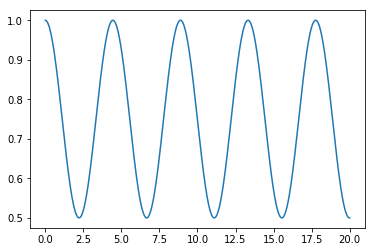

In [28]:
plt.plot(soln.t,soln.y[0])